# Theory 
Fitting the energy volume curve allows to calculate the equilibrium energy $E_0$, the equilirbium volume $V_0$, the equilibrium bulk modulus $B_0$ and its derivative $B^{'}_0$. These quantities can then be used as part of the Einstein model to get an initial prediction for the thermodynamik properties, the heat capacity $C_v$ and the free energy $F$. 

# Initialisation

We start by importing matplotlib, numpy and the pyiron project class. 

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from pyiron import Project

In the next step we create a project, by specifying the name of the project. In addition we remove all jobs which might exist in the project before to have a clean project for our example. 

In [2]:
pr = Project(path='thermo')
pr.remove_jobs(recursive=True)

# Atomistic structure

To analyse the energy volume dependence a single super cell is sufficient, so we create an iron super cell as an example.

In [3]:
basis = pr.create_structure(element='Fe', bravais_basis='bcc', lattice_constant=2.75)
basis.plot3d()

NGLWidget()

# Calculation
Energy volume curves are commonly calculated with ab initio codes, so we use VASP in this example. But we focus on the generic commands so the same example works with any DFT code. We choose 'vasp' as job name prefix, select an energy cut off of $320 eV$ and assign the basis to the job. Afterwards we apply the corresponding strain.

In [4]:
for strain in np.linspace(0.97, 1.03, 7):
    strain_str = str(strain).replace('.', '_')
    job_vasp_strain = pr.create_job(job_type=pr.job_type.Vasp, job_name='vasp_' + strain_str)
    job_vasp_strain.set_encut(320.0)
    job_vasp_strain.structure = basis.copy()
    job_vasp_strain.structure.set_cell(cell=basis.cell * strain ** (1/3), scale_atoms=True)
    job_vasp_strain.run()

The job vasp_0_97 was saved and received the ID: 1880776
The job vasp_0_98 was saved and received the ID: 1880777
The job vasp_0_99 was saved and received the ID: 1880778
The job vasp_1_0 was saved and received the ID: 1880779
The job vasp_1_01 was saved and received the ID: 1880780
The job vasp_1_02 was saved and received the ID: 1880781
The job vasp_1_03 was saved and received the ID: 1880783


As these are simple calculation, there is no need to submit them to the queuing sytem. We can confirm the status of the calculation with the job_table. If the status of each job is marked as finished, then we can continue with the next step.

In [5]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1880776,finished,Fe2,vasp_0_97,/vasp_0_97,/cmmc/u/,janj/PyIron_data/projects/2018-10-17-pyiron-meeting/thermo/,2018-10-17 14:45:29.096323,2018-10-17 14:45:31.890086,2.0,janj@cmmc001#1,Vasp,5.3,None,None
1,1880777,finished,Fe2,vasp_0_98,/vasp_0_98,/cmmc/u/,janj/PyIron_data/projects/2018-10-17-pyiron-meeting/thermo/,2018-10-17 14:45:32.635219,2018-10-17 14:45:33.517737,0.0,janj@cmmc001#1,Vasp,5.3,None,None
2,1880778,finished,Fe2,vasp_0_99,/vasp_0_99,/cmmc/u/,janj/PyIron_data/projects/2018-10-17-pyiron-meeting/thermo/,2018-10-17 14:45:34.207757,2018-10-17 14:45:35.073940,0.0,janj@cmmc001#1,Vasp,5.3,None,None
3,1880779,finished,Fe2,vasp_1_0,/vasp_1_0,/cmmc/u/,janj/PyIron_data/projects/2018-10-17-pyiron-meeting/thermo/,2018-10-17 14:45:35.766127,2018-10-17 14:45:36.628651,0.0,janj@cmmc001#1,Vasp,5.3,None,None
4,1880780,finished,Fe2,vasp_1_01,/vasp_1_01,/cmmc/u/,janj/PyIron_data/projects/2018-10-17-pyiron-meeting/thermo/,2018-10-17 14:45:37.349526,2018-10-17 14:45:38.210085,0.0,janj@cmmc001#1,Vasp,5.3,None,None
5,1880781,finished,Fe2,vasp_1_02,/vasp_1_02,/cmmc/u/,janj/PyIron_data/projects/2018-10-17-pyiron-meeting/thermo/,2018-10-17 14:45:38.903688,2018-10-17 14:45:39.759347,0.0,janj@cmmc001#1,Vasp,5.3,None,None
6,1880783,finished,Fe2,vasp_1_03,/vasp_1_03,/cmmc/u/,janj/PyIron_data/projects/2018-10-17-pyiron-meeting/thermo/,2018-10-17 14:45:40.434831,2018-10-17 14:45:41.323070,0.0,janj@cmmc001#1,Vasp,5.3,None,None


# Analysis

We aggregate the data for further processing in two separated lists, one for the volumes and one for the energies. To do so we iterate over the jobs within the project, filter the job names which contain the string 'vasp' and from those extract the final volume and the final energy. 

In [6]:
volume_lst, energy_lst = zip(*[[job['output/generic/volume'][-1], job['output/generic/energy_tot'][-1]] 
                               for job in pr.iter_jobs(convert_to_object=False) if 'vasp' in job.job_name])   

We plot the aggregated data using matplotlib. 

Text(0, 0.5, 'Energy (eV)')

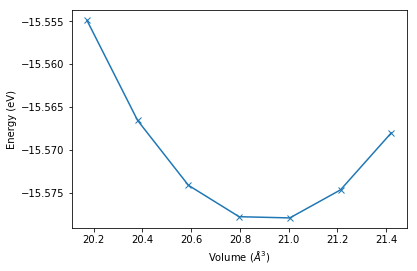

In [7]:
plt.plot(volume_lst, energy_lst, 'x-')
plt.xlabel('Volume ($\AA ^ 3$)')
plt.ylabel('Energy (eV)')

# Encut Dependence
To extend the complexity of our simulation protocol we can not only iterate over different strains but also different energy cutoffs. For this we use multiple sub projects to structure the data. And we summarize the previous code in multiple functions to maintain a high level of readability. The first function calculates a specific strained configuration for an specifc energy cut off, while the second function analyses the different strained calculations for a specific energy cutoff and returns the list of energy volume pairs.

## Functions

In [8]:
def vasp_calculation_for_strain(pr, basis, strain, encut):
    strain_str = str(strain).replace('.', '_')
    job_vasp_strain = pr.create_job(job_type=pr.job_type.Vasp, job_name='vasp_' + strain_str)
    job_vasp_strain.set_encut(encut)
    job_vasp_strain.structure = basis.copy()
    job_vasp_strain.structure.set_cell(cell=basis.cell * strain ** (1/3), scale_atoms=True)
    job_vasp_strain.run()

In [9]:
def energy_volume_pairs(pr):
    volume_lst, energy_lst = zip(*[[job['output/generic/volume'][-1], job['output/generic/energy_tot'][-1]] 
                               for job in pr.iter_jobs(convert_to_object=False) if 'vasp' in job.job_name])
    return volume_lst, energy_lst

## Calculation

With these functions we can structure our code and implement the additional for loop to include multiple energy cutoffs.

In [10]:
for encut in np.linspace(270, 320, 6):
    encut_str = 'encut_' + str(int(encut))
    pr_encut = pr.open(encut_str)
    for strain in np.linspace(0.97, 1.03, 7):
        vasp_calculation_for_strain(pr=pr_encut, 
                                    basis=basis, 
                                    strain=strain, 
                                    encut=encut)

The job vasp_0_97 was saved and received the ID: 1880784
The job vasp_0_98 was saved and received the ID: 1880785
The job vasp_0_99 was saved and received the ID: 1880786
The job vasp_1_0 was saved and received the ID: 1880787
The job vasp_1_01 was saved and received the ID: 1880788
The job vasp_1_02 was saved and received the ID: 1880789
The job vasp_1_03 was saved and received the ID: 1880790
The job vasp_0_97 was saved and received the ID: 1880791
The job vasp_0_98 was saved and received the ID: 1880792
The job vasp_0_99 was saved and received the ID: 1880793
The job vasp_1_0 was saved and received the ID: 1880794
The job vasp_1_01 was saved and received the ID: 1880796
The job vasp_1_02 was saved and received the ID: 1880797
The job vasp_1_03 was saved and received the ID: 1880798
The job vasp_0_97 was saved and received the ID: 1880799
The job vasp_0_98 was saved and received the ID: 1880800
The job vasp_0_99 was saved and received the ID: 1880801
The job vasp_1_0 was saved and re

## Analysis 

The analysis is structured in a similar way. Here we use iter_groups() to iterate over the existing subprojects within our project and plot the individual energy volume curves using the functions defined above. 

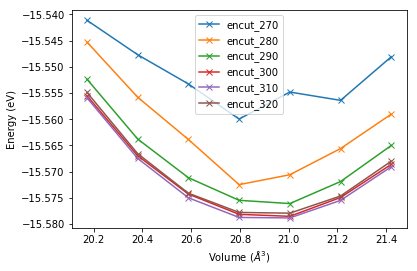

In [11]:
for pr_encut in pr.iter_groups():
    volume_lst, energy_lst = energy_volume_pairs(pr_encut)
    plt.plot(volume_lst, energy_lst, 'x-', label=pr_encut.base_name)
plt.xlabel('Volume ($\AA ^ 3$)')
plt.ylabel('Energy (eV)')
plt.legend()

# Fitting
After we created multiple datasets we can now start to fit the converged results. While it is possible to fit the results using a simple polynomial fit we prefer to use the phyiscally motivated birch murnaghan equation or the vinet equation. For this we create the Murnaghan object and use it is fitting functionality:

In [12]:
murn = pr.create_job(job_type=pr.job_type.Murnaghan, job_name='murn')

## Birch Marnaghan

In [13]:
[e0, b0, bP, v0], [e0_error, b0_error, bP_error, v0_error] = murn._fit_leastsq(volume_lst=volume_lst,
                                                                               energy_lst=volume_lst,
                                                                               fittype='birchmurnaghan')
[e0, b0, bP, v0] 

/u/janj/PyIron_data/plugins/pyiron_atomistics/pyiron_atomistics/hamilton/murnaghan.py:318: RuntimeWarning: invalid value encountered in power
  eta = (V0 / V) ** (1 / 3)


[-205329195976123.8, -160.2176620799938, 4.0, -410658391952263.56]

## Vinet

In [14]:
[e0, b0, bP, v0], [e0_error, b0_error, bP_error, v0_error] = murn._fit_leastsq(volume_lst=volume_lst,
                                                                               energy_lst=energy_lst,
                                                                               fittype='vinet')
[e0, b0, bP, v0] 

[-15.578333798068424, 272.9051501085194, 4.724040192260722, 20.906161569952577]

We see that both equation of states give slightly different results, with overall good agreement. To validate the agreement we plot the with with the original data.

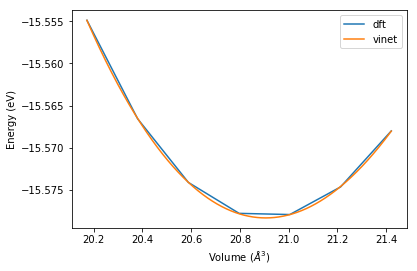

In [15]:
vol_lst = np.linspace(np.min(volume_lst), np.max(volume_lst), 1000)
plt.plot(volume_lst, energy_lst, label='dft')
plt.plot(vol_lst, murn.vinet_energy(vol_lst, e0, b0/ 160.21766208, bP, v0), label='vinet')
plt.xlabel('Volume ($\AA ^ 3$)')
plt.ylabel('Energy (eV)')
plt.legend()

# Murnaghan Module 
Besides the fitting capabilities the Murnaghan module can also be used to run a set of calculations. For this we define a reference job, which can be either a Vasp calculation or any other pyiron job type and then specify the input parameters for the Murnaghan job.

In [16]:
job_vasp_strain = pr.create_job(job_type=pr.job_type.Vasp, job_name='vasp')
job_vasp_strain.set_encut(320)
job_vasp_strain.structure = basis.copy()

In [17]:
murn = pr.create_job(job_type=pr.job_type.Murnaghan, job_name='murn')
murn.ref_job = job_vasp_strain
murn.input

,Parameter,Value,Comment
0,num_points,11.0,number of sample points
1,fit_order,3.0,order of the fit polynom
2,vol_range,0.1,relative volume variation around volume defined by ref_ham


We modify the input parameters to agree with the settings used in the examples above and execute the simulation by calling the run command on the murnaghan job object.

In [18]:
murn.input['num_points'] = 7
murn.input['vol_range'] = 0.03

In [19]:
murn.run()

The job murn was saved and received the ID: 1880829
The job strain_0_97 was saved and received the ID: 1880830
The job strain_0_98 was saved and received the ID: 1880831
The job strain_0_99 was saved and received the ID: 1880832
The job strain_1_0 was saved and received the ID: 1880833
The job strain_1_01 was saved and received the ID: 1880834
The job strain_1_02 was saved and received the ID: 1880835
The job strain_1_03 was saved and received the ID: 1880836
job_id:  1880830 finished
job_id:  1880831 finished
job_id:  1880832 finished
job_id:  1880833 finished
job_id:  1880834 finished
job_id:  1880835 finished
job_id:  1880836 finished


Afterwards we can use the build in capabilites to plot the resulting energy volume curve and fit different equations of state to the calculated energy volume pairs.

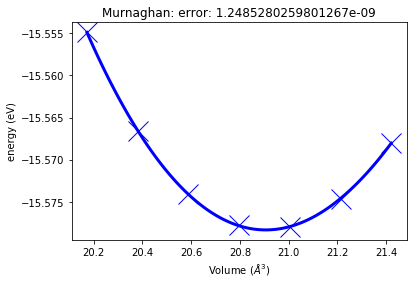

In [20]:
murn.plot()

In [21]:
murn.fit_vinet()

{'b_prime_eq': 4.724040192260722,
 'bulkmodul_eq': 272.9051501085194,
 'energy_eq': -15.578333798068424,
 'least_square_error': array([3.45792309e-05, 1.18134489e+00, 5.53018488e-01, 1.29401860e-03]),
 'volume_eq': 20.906161569952577}

# Common mistakes 

## Not copying the basis 

It is important to copy the basis before applying the strain, as the strain has to be applied on the initial structure, not the previous structure:

In [22]:
volume_lst_with_copy = []
for strain in np.linspace(0.97, 1.03, 7):
    basis_copy = basis.copy()
    basis_copy.set_cell(cell=basis.cell * strain ** (1/3), scale_atoms=True)
    volume_lst_with_copy.append(basis_copy.get_volume())

In [23]:
basis_copy = basis.copy()
volume_lst_without_copy = []
for strain in np.linspace(0.97, 1.03, 7):
    basis_copy.set_cell(cell=basis_copy.cell * strain ** (1/3), scale_atoms=True)
    volume_lst_without_copy.append(basis_copy.get_volume())

In [24]:
volume_lst_with_copy, volume_lst_without_copy

([20.17296874999999,
  20.380937499999995,
  20.588906250000004,
  20.796874999999996,
  21.004843749999992,
  21.212812500000016,
  21.42078124999999],
 [20.17296874999999,
  19.769509374999995,
  19.571814281250003,
  19.571814281250003,
  19.76753242406251,
  20.162883072543767,
  20.767769564720073])

## Rescaling the cell

Another common issue is the rescaling of the supercell, there are multiple options to choose from. We used the option to scale the atoms with the supercell.

In [25]:
basis_copy = basis.copy()
strain = 0.5
basis_copy.set_cell(cell=basis_copy.cell * strain ** (1/3), scale_atoms=True)
basis_copy.plot3d()

NGLWidget()

A nother typical case is rescaling the cell to increase the distance between the atoms or add vacuum. But that is not what we want to fit an energy volume curve.

In [26]:
basis_copy = basis.copy()
strain = 0.5
basis_copy.set_cell(cell=basis_copy.cell * strain ** (1/3), scale_atoms=False)
basis_copy.plot3d()

NGLWidget()

The same can be achieved by setting the basis to relative coordinates.

In [27]:
basis_copy = basis.copy()
strain = 0.5
basis_copy.set_relative()
basis_copy.cell *= strain ** (1/3)
basis_copy.plot3d()

NGLWidget()

In [28]:
basis_copy = basis.copy()
strain = 0.5
basis_copy.cell *= strain ** (1/3)
basis_copy.plot3d()

NGLWidget()